# Planar.ai Code

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
%matplotlib inline

## Survey Feedback System
Goal : Determine the likelyhood of an employee coming to work in-person on a certain day of the week.

Survey Link : https://docs.google.com/forms/d/1tbhFI7JkYJxe8bbO3fN_p8H5UTHRajab9fa2lioqtQM/edit?usp=sharing

### Creating Sample Survey Response Dataset

In [53]:
num_samples = 1000

survey_df = pd.DataFrame(columns = ["age", "years_in_comapny","commute_duration", "hours_in_office", "days_in_office", 
                                    "num_coworkers_speak", "productivity_level","social_interaction_level", 
                                    "private_room?", "social_room?", "cafe?", "likely_return"])
for sample in range(num_samples):
    age = np.random.choice(range(21,56))
    years_in_company = np.random.choice(range(1,25))
    commute_duration = np.random.choice(range(1,4))
    hours_in_office = np.random.choice(range(1,13))
    days_in_office = np.random.choice(range(1,6))
    num_coworkers_speak = np.random.choice(range(1,21))
    productivity_level = np.random.choice(range(1,6))
    social_interaction_level = np.random.choice(range(1,6))
    private_room = np.random.choice(range(0,2))
    social_room = np.random.choice(range(0,2))
    cafe = np.random.choice(range(0,2))
    likely_return = np.random.choice(range(0,10))
    survey_df.loc[len(survey_df)] = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, productivity_level,social_interaction_level,private_room,
                                 social_room, cafe, likely_return]
survey_df 

,age,years_in_comapny,commute_duration,hours_in_office,days_in_office,num_coworkers_speak,productivity_level,social_interaction_level,private_room?,social_room?,cafe?,likely_return
0,30,8,1,7,4,3,5,2,1,1,1,8
1,29,8,3,12,5,19,3,2,1,1,0,6
2,25,18,1,1,1,2,1,1,0,1,1,9
3,31,7,2,10,4,7,4,5,1,0,0,9
4,26,10,1,11,5,5,4,5,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,29,9,2,5,1,15,1,4,0,0,0,7
996,53,9,3,8,2,1,2,5,1,0,1,1
997,40,3,3,2,3,4,4,3,1,1,1,1
998,26,8,2,8,1,15,2,2,1,0,1,9


### Splitting Data 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(survey_df.drop(columns = ["likely_return"]), survey_df["likely_return"], test_size=0.33)


### Generating Model

In [60]:
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

###  Model Hyperparameter Tuning

In [82]:
def tune_model(depth_range, X_train, X_test, y_train, y_test):
    train_accs = []
    test_accs = []
    depths = depth_range
    for depth in depths:  
        clf = OrdinalClassifier(DecisionTreeClassifier(max_depth = depth))
        clf.fit(X_train, y_train)
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        train_accs.append(accuracy_score(train_preds, y_train))
        test_accs.append(accuracy_score(test_preds, y_test))
    plt.figure(figsize = (10,8))
    plt.plot(depths, train_accs, label = "Training Accuracy")
    plt.plot(depths, test_accs, label = "Testing Accuracy")
    plt.xlabel("Model Tree Depth")
    plt.ylabel("Model Accuracy")
    plt.title("Model Accuracy with Varying Depth");
    best_train_depth = np.argmax(train_accs) + 1
    best_test_depth = np.argmax(test_accs) + 1
    print("Best Training Accuracy at depth =", best_train_depth)
    print("Best Testing Accuracy at depth =", best_test_depth)
    return best_train_depth, best_test_depth

Best Training Accuracy at depth = 18
Best Testing Accuracy at depth = 81


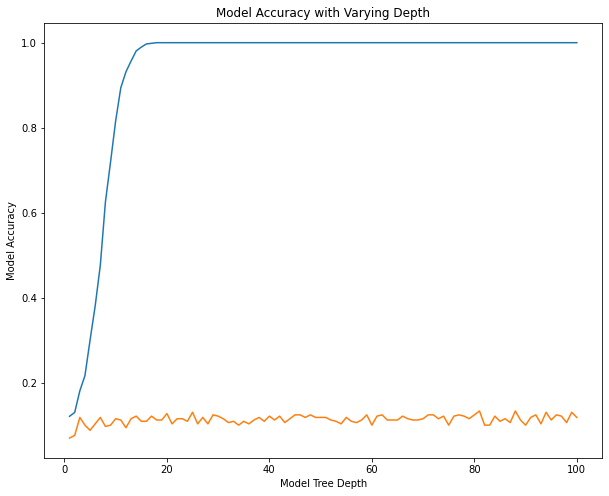

In [83]:
best_train_depth, best_test_depth = tune_model(range(1,101), X_train, X_test, y_train, y_test)

### Output Final Model

In [86]:
def train_model(best_depth, X_train, y_train):
    clf = OrdinalClassifier(DecisionTreeClassifier(max_depth = best_depth))
    clf.fit(X_train, y_train)
    return clf

In [88]:
best_model = train_model(best_test_depth, X_train, y_train)
best_model

### Predict Likelyhood for New User

In [95]:
age = 24
years_in_company = 3
commute_duration = 1
hours_in_office = 6
days_in_office = 5
num_coworkers_speak = 6
productivity_level = 4
social_interaction_level = 5
private_room = 0
social_room = 1
cafe = 1

new_test = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, productivity_level,social_interaction_level,private_room,
                                 social_room, cafe]
new_prediction = best_model.predict(np.array(new_test).reshape(1,-1))[0] + 1
print("This new user's likelyhood of returning to the office on the same day next week is", new_prediction, "on a scale of 1-10")


This new user's likelyhood of returning to the office on the same day next week is 6 on a scale of 1-10
